In [1]:
%reload_ext autoreload
%autoreload 2


import functools
print = functools.partial(print, flush=True)

import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # for pdfs
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import pickle
from tqdm import tqdm
import scipy

import flexiznam as flz
from cottage_analysis.analysis import spheres, common_utils, find_depth_neurons
from cottage_analysis.pipelines import pipeline_utils
from v1_depth_analysis.v1_manuscript_2023 import depth_selectivity, get_session_list

from matplotlib_venn import venn2, venn3

In [2]:
project='hey2_3d-vision_foodres_20220101'
session_name='PZAH6.4b_S20220426'
flexilims_session = flz.get_flexilims_session(project)

vs_df, trials_df = spheres.sync_all_recordings(
    session_name=session_name,
    flexilims_session=flexilims_session,
    project=project,
    filter_datasets={'anatomical_only':3},
    recording_type="two_photon",
    protocol_base="SpheresPermTubeReward",
    photodiode_protocol=2,
    return_volumes=True,
)

neurons_ds = pipeline_utils.create_neurons_ds(
    session_name=session_name, flexilims_session=flexilims_session, project=None, conflicts="skip"
)
neurons_df = pd.read_pickle(neurons_ds.path_full)

Processing recording 1/1
Loading existing monitor frames...
Removing frames in wrong order of frame indices.
Removed 0 frames including:
0 negative diffs.
0 duplicates.
2 frames are not 0.0658 s
ImagingFrames in video: 97615
ImagingFrame triggers: 97616


/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/preprocessing/synchronisation.py:435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imaging_df["imaging_harptime_end"].iloc[-1] = (
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/spheres.py:295: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  imaging_df.RS = imaging_df.mouse_z_harp.diff() / imaging_df.mouse_z_harptime.diff()
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/spheres.py:297: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#at

Finished concatenating vs_df and trials_df


In [3]:
neurons_df_mini, neurons_ds = find_depth_neurons.fit_preferred_depth(
    trials_df=trials_df,
    neurons_df=neurons_df,
    neurons_ds=neurons_ds,
    closed_loop=1,
    choose_trials=None,
    depth_min=0.02,
    depth_max=20,
    niter=10,
    min_sigma=0.5,
    k_folds=1,
)

# Find preferred depth of closed loop with half the data for plotting purposes
neurons_df_mini, neurons_ds = find_depth_neurons.fit_preferred_depth(
    trials_df=trials_df,
    neurons_df=neurons_df,
    neurons_ds=neurons_ds,
    closed_loop=1,
    choose_trials="odd",
    depth_min=0.02,
    depth_max=20,
    niter=10,
    min_sigma=0.5,
    k_folds=1,
)

# Find r-squared of k-fold cross validation
neurons_df_mini, neurons_ds = find_depth_neurons.fit_preferred_depth(
    trials_df=trials_df,
    neurons_df=neurons_df,
    neurons_ds=neurons_ds,
    closed_loop=1,
    choose_trials=None,
    depth_min=0.02,
    depth_max=20,
    niter=10,
    min_sigma=0.5,
    k_folds=5,
)

100%|██████████| 795/795 [03:58<00:00,  3.33it/s]


In [21]:
neurons_df.columns

Index(['roi', 'is_depth_neuron', 'depth_neuron_anova_p', 'best_depth',
       'preferred_depth_closedloop', 'depth_tuning_popt_closedloop',
       'depth_tuning_trials_closedloop', 'preferred_depth_closedloop_crossval',
       'depth_tuning_popt_closedloop_crossval',
       'depth_tuning_trials_closedloop_crossval',
       'depth_tuning_test_rsq_closedloop', 'preferred_RS_closedloop',
       'preferred_OF_closedloop', 'rsof_popt_closedloop',
       'rsof_rsq_closedloop', 'preferred_RS_openloop_actual',
       'preferred_OF_openloop_actual', 'rsof_popt_openloop_actual',
       'rsof_rsq_openloop_actual', 'preferred_RS_openloop_virtual',
       'preferred_OF_openloop_virtual', 'rsof_popt_openloop_virtual',
       'rsof_rsq_openloop_virtual', 'rf_coef', 'rf_rsq', 'rf_coef_ipsi',
       'rf_rsq_ipsi', 'depth_tuning_test_spearmanr_rval_closedloop',
       'depth_tuning_test_spearmanr_pval_closedloop'],
      dtype='object')

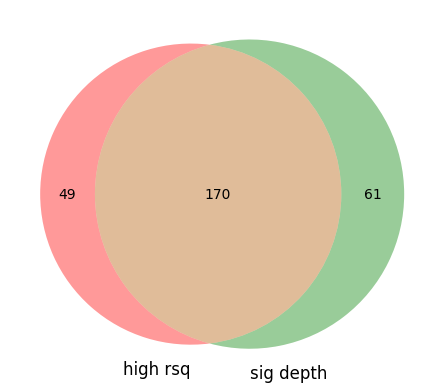

In [4]:
# Check if there's significant overlap between neurons with high r-squared and neurons with significant depth tuning
high_rsq = (neurons_df_mini["depth_tuning_test_rsq_closedloop"] > 0.01)
sig_depth = (neurons_df_mini["depth_tuning_test_spearmanr_pval_closedloop"] < 0.05)
venn3([set(neurons_df_mini[high_rsq].roi.values), set(neurons_df_mini[sig_depth].roi.values)], set_labels=["high rsq", "sig depth"])

In [6]:
np.mean(neurons_df_mini["depth_tuning_test_spearmanr_pval_closedloop"]>0.05)

0.7094339622641509

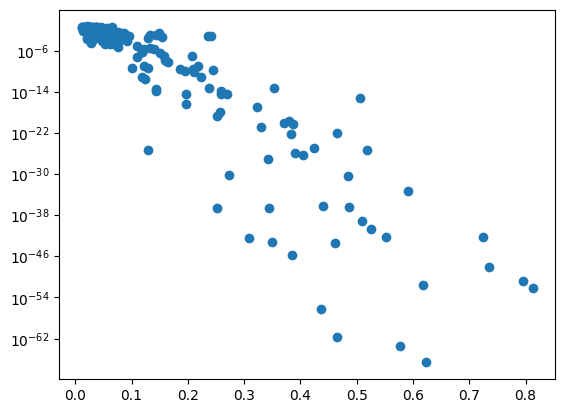

In [30]:
select = (neurons_df_mini["depth_tuning_test_rsq_closedloop"] > 0.01) & (neurons_df_mini["depth_tuning_test_spearmanr_pval_closedloop"] < 0.05)
plt.scatter(neurons_df_mini[select]["depth_tuning_test_rsq_closedloop"], neurons_df_mini[select]["depth_tuning_test_spearmanr_pval_closedloop"])
# plt.xscale("log")
plt.yscale("log")